In [1]:
#!/usr/bin/env python
"""
Demo for Emoji dynamic tomography test problem
--------------------------------------------------------------------------
Created in 2023 for TRIPs-Py library
"""
__authors__ = "Mirjeta Pasha, Silvia Gazzola, Connor Sanderford, and Ugochukwu Obinna Ugwu"
__affiliations__ = 'Tufts University, University of Bath, Arizona State University, and Tufts University'
__copyright__ = "Copyright 2023, TRIPs-Py library"
__license__ = "GPL"
__version__ = "1.0"
__email__ = "mirjeta.pasha@tufts.edu; mirjeta.pasha1@gmail.com; sg968@bath.ac.uk; csanderf@asu.edu; connorsanderford@gmail.com; Ugochukwu.Ugwu@tufts.edu"

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.linalg import fractional_matrix_power
from numpy import array, diag, dot, maximum, empty, repeat, ones, sum
from numpy.linalg import inv
parameters = {'xtick.labelsize': 12, 'ytick.labelsize': 12,
          'axes.titlesize': 18, 'axes.labelsize': 18, 'figure.titlesize': 14, 'legend.fontsize': 13}
plt.rcParams.update(parameters)
import scipy as sp
import scipy.stats as sps
import scipy.io as spio
import astra
from venv import create
import pylops
from scipy.ndimage import convolve
from scipy import sparse
from scipy.ndimage import convolve
import scipy.special as spe
import requests
import h5py
# functions to generate emoji data are stored in io_l.py
from trips.utilities.io import *
from trips.utilities.operators import *
from trips.solvers.AnisoTV import *
from trips.utilities.helpers import *
from trips.solvers.GKS import *
from trips.solvers.MMGKS import *

# Notebook 1: Emoji test problem

<p>In this example we illustrate the following:
<p>&nbsp; Step 1: Download/read the emoji data and prepare them for processing.
<p>&nbsp; Step 2: Solve the static inverse problem.
<p>&nbsp; Step 3: Solve the dynamic inverse problem.

Emoji data are generated at the University of Helsinki: https://zenodo.org/record/1183532#.YyaW_C9h2fU


#### Step 1: Download/read the data and prepare them for processing
##### The main function to generate the emoji data is generate_emoji(dataset, noise_level) 
<p> <b>Input:</b> 
<p>&nbsp; <b>dataset:</b>
        <p>&nbsp; if dataset = 30, we generate data from DataDynamic_128x30.mat
        <p>&nbsp; if dataset = 60, we generate data from DataDynamic_128x60.mat
<p>&nbsp; <b>noise_level:</b>
        <p>&nbsp; Emoji data are real data and they have noise. Hence, we set noise_level = 0
            
<p> <b>Output:</b>  
&nbsp;<br> <b>A:</b> The full forward operator for all time instances<br>
&nbsp; <b>b:</b> All the data/measurements vectorized<br> 
&nbsp; <b>AA:</b> A list of 33 time-wise operators<br> 
&nbsp; <b>B:</b> A list of 33 data vectors for each time instance <br> 
&nbsp; <b>nx:</b> The dimension of the first spatial domain<br> 
&nbsp; <b>ny:</b> The dimension of the second spatial domain<br> 
&nbsp; <b>nt:</b> The dimension of the time instances domain<br> 
&nbsp; <b>delta:</b> The noise level in the data. When we set noise_level == 0, we get delta = 0<br> 
&nbsp; <b>sinoshape:</b> The dimension of the time-wise sinogram<br>     

In [3]:
(A, b, AA, B, nx, ny, nt, delta) = generate_emoji(noise_level = 0, dataset = 30)

data already downloaded.


#### Step 2: Solve the static inverse problems.
<p>&nbsp; <b>The function to perform reconstruction is reconstruct_anisoTV(dynamic)</b>
<p> <b>Input:</b> 
<p>&nbsp; <b>dynamic:</b>
        <p>&nbsp; if dynamic = True, it solves the dynamic inverse problem $A x = b$
        <p>&nbsp; if dynamic = False, it solves nt static inverse problems $AA(i) x(i) = B(i)$, for i in range(nt)
<p> <b>Output:</b>  
&nbsp;<br> <b>xx:</b> <br>If dynamic == True, xx is a 3 dimensional tensor with dimensions (nx, ny, nt) that contains nt reconstructed images<br>If dynamic == False, xx is a list with nt elements that contains nt reconstructed images

In [30]:
# Compute a solution by GKS
# Define a derivative operator as a regularization operator
# L = spatial_derivative_operator(nx, ny, nt)
A1 = AA[1]
b1 = B[1]
L = gen_first_derivative_operator_2D(nx, ny)
data_vec = b.reshape((-1,1))
# Use GKS to compute an approximate solution
(x_mmgks_1, info_mmgks_1) = MMGKS(A1, b1.reshape((-1,1)), L, pnorm=2, qnorm=1, projection_dim=1, n_iter = 50, regparam = 0.00055, x_true = None, delta = delta, epsilon = 0.001)

running MMGKS...: 100%|██████████| 50/50 [00:02<00:00, 17.00it/s]


In [55]:
xx = list(range(nt))
L = spatial_derivative_operator(nx, ny, 1)
for i in range(nt):
    b_vec = B[i].reshape((-1,1))
    (x_static_mmgks, info_mmgks) = MMGKS(AA[i], b_vec, L, pnorm=2, qnorm=1, projection_dim=1, n_iter = 50, regparam= 'gcv' , x_true=None, epsilon = 0.001)
    xx[i] = x_static_mmgks

running MMGKS...: 100%|██████████| 10/10 [00:03<00:00,  2.80it/s]


<Figure size 432x288 with 0 Axes>

<Figure size 3600x3600 with 0 Axes>

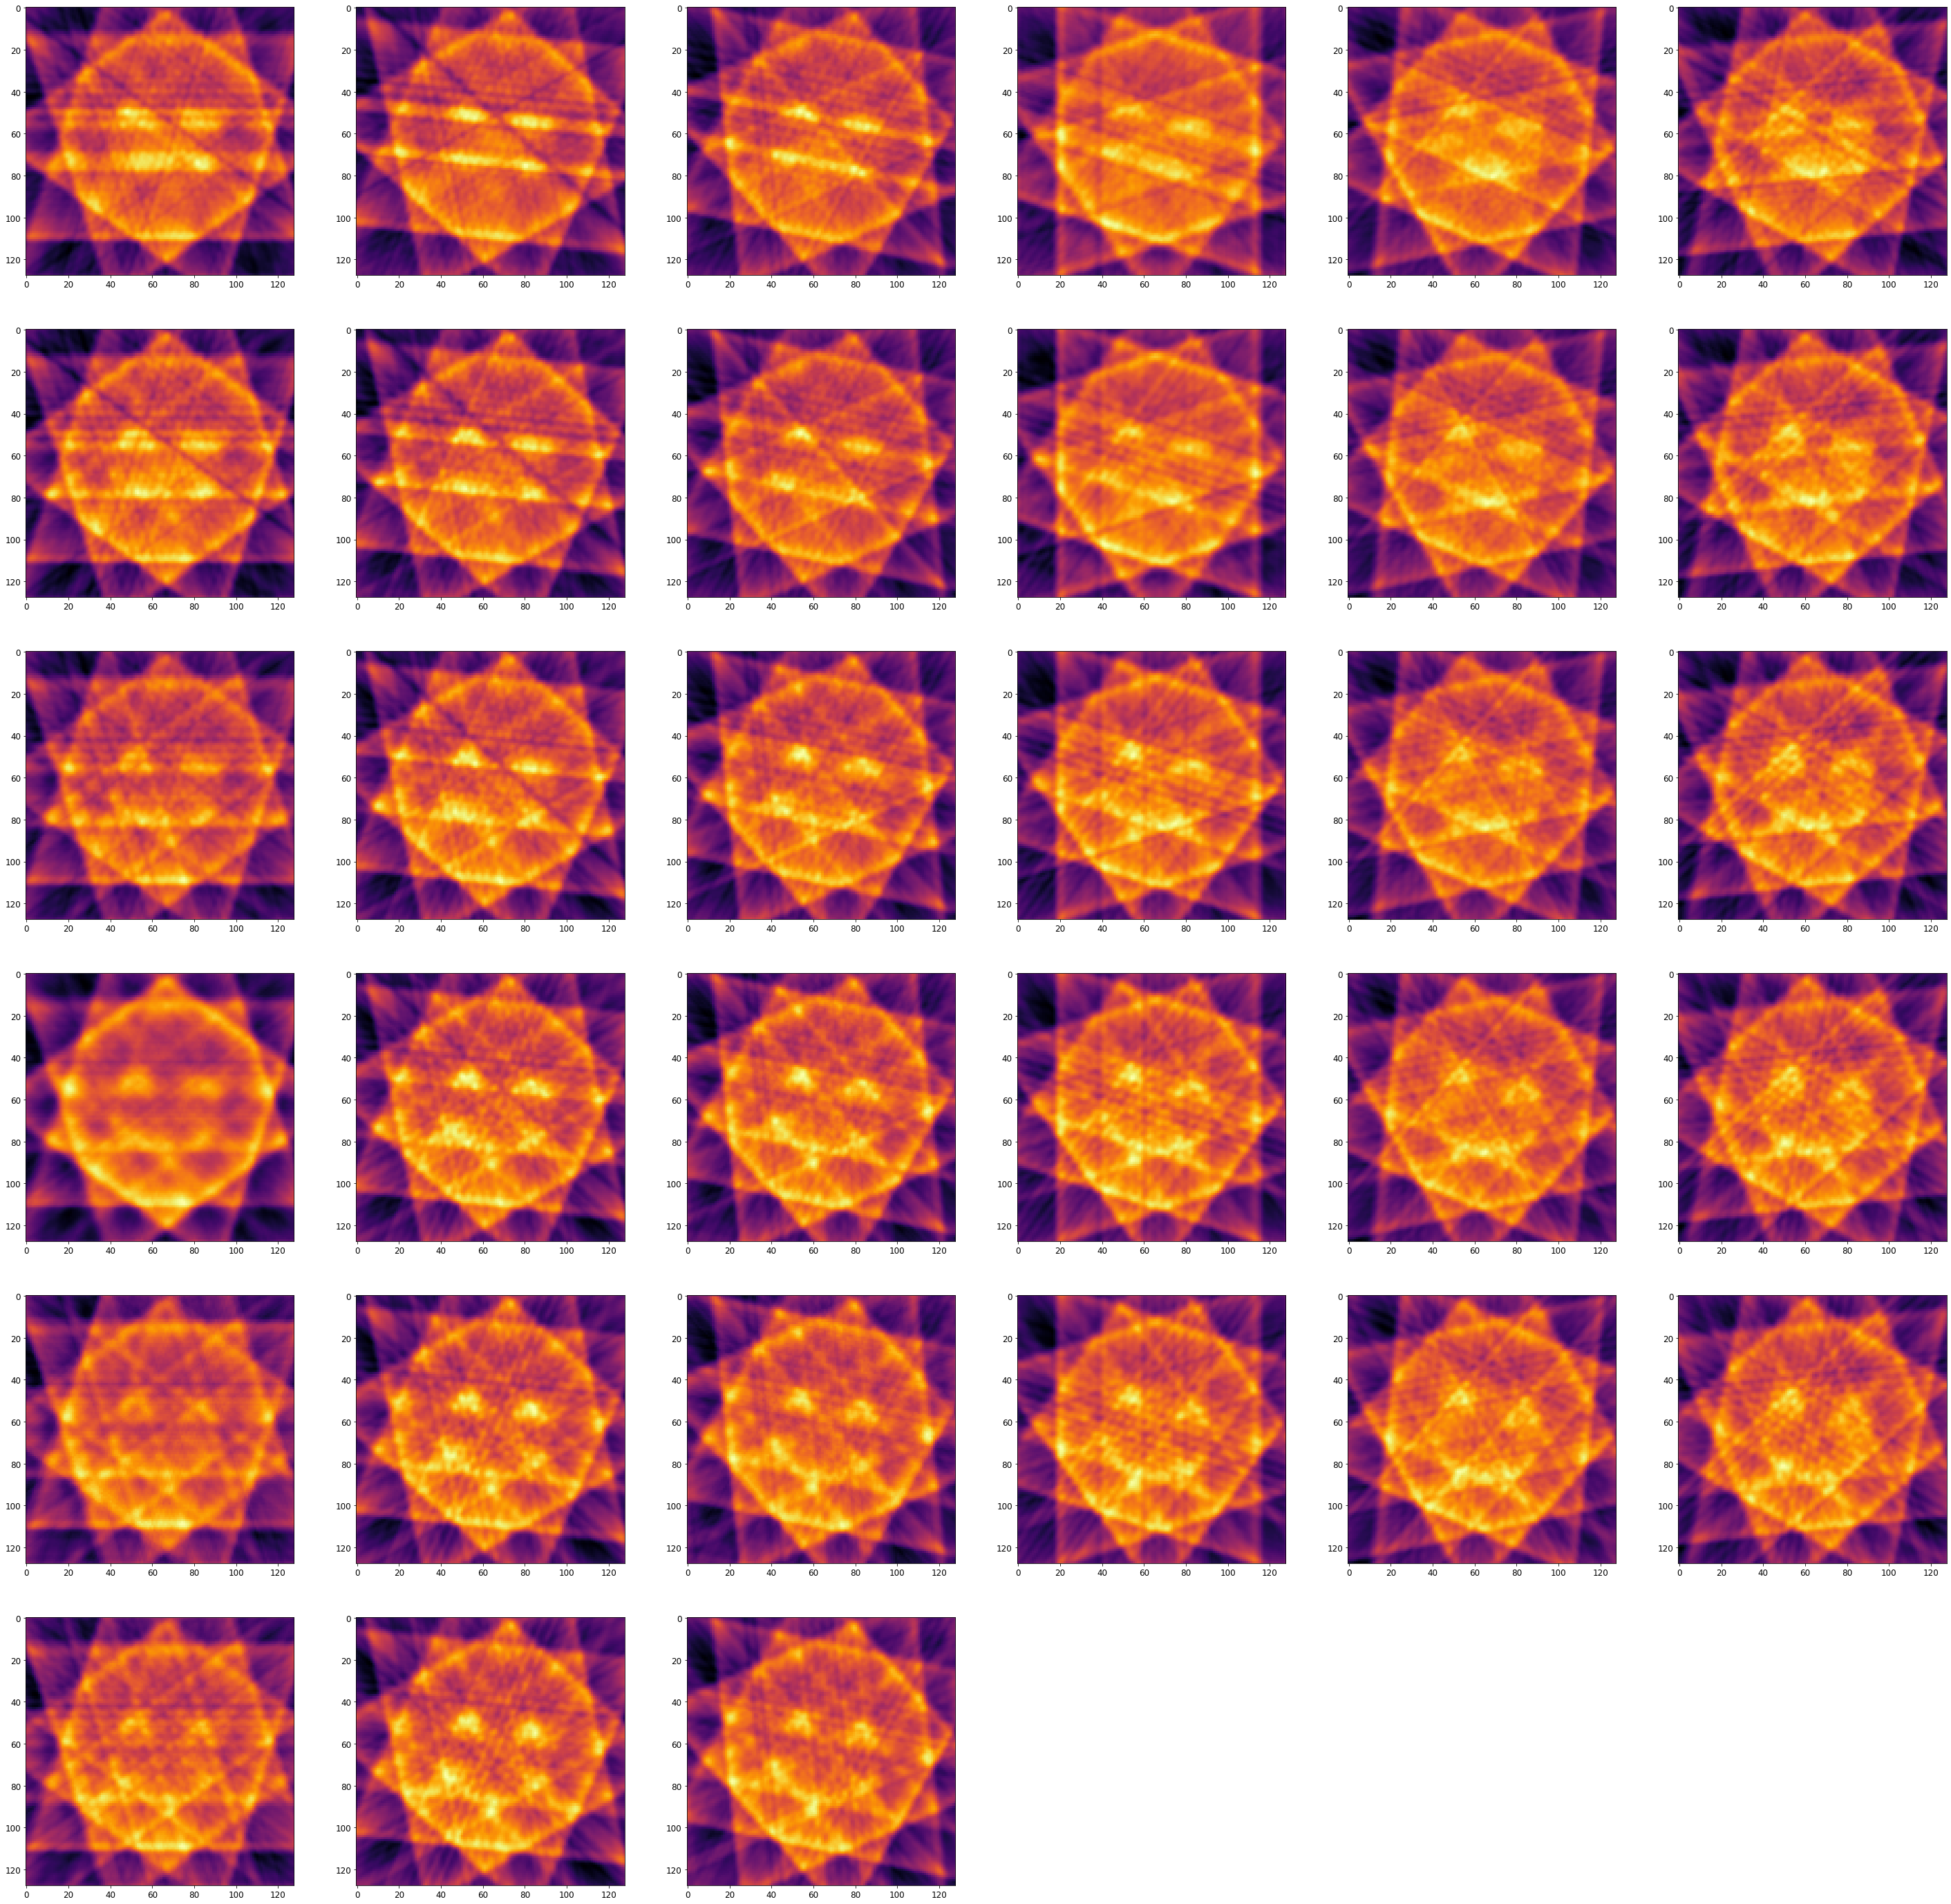

In [56]:
plot_recstructions_series(xx, (nx, ny, nt), dynamic = False, testproblem = 'Emoji', geome_x = 1,geome_x_small = 0,  save_imgs= False, save_path='./reconstruction/Emoji')

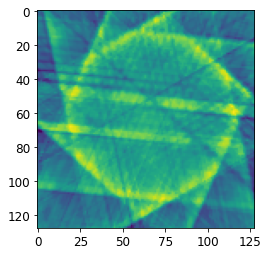

In [31]:
plt.imshow(x_mmgks_1.reshape((nx, ny)))

#### Step 3: Solve dynamic inverse problems.
<p>&nbsp; <b>The function to perform reconstruction is reconstruct_anisoTV(dynamic)</b>
<p> <b>Input:</b> 
<p>&nbsp; <b>dynamic:</b>
        <p>&nbsp; if dynamic = True, it solves the dynamic inverse problem $A x = b$
        <p>&nbsp; if dynamic = False, it solves nt static inverse problems $AA(i) x(i) = B(i)$, for i in range(nt)
<p> <b>Output:</b>  
&nbsp;<br> <b>xx:</b> <br>If dynamic == True, xx is a 3 dimensional tensor with dimensions (nx, ny, nt) that contains nt reconstructed images<br>If dynamic == False, xx is a list with nt elements that contains nt reconstructed images

In [57]:
# Compute a solution by GKS
# Define a derivative operator as a regularization operator
# L = spatial_derivative_operator(nx, ny, nt)
L = gen_spacetime_derivative_operator(nx, ny, nt)
data_vec = b.reshape((-1,1))
# Use GKS to compute an approximate solution
(x_mmgks, info_mmgks) = MMGKS(A, data_vec, L, pnorm=2, qnorm=1, projection_dim=1, n_iter = 50, regparam = 'gcv', x_true = None, delta = delta, epsilon = 0.001)

running MMGKS...: 100%|██████████| 50/50 [02:23<00:00,  2.87s/it]


In [59]:
x_mmgks[x_mmgks<0] = 0

<Figure size 432x288 with 0 Axes>

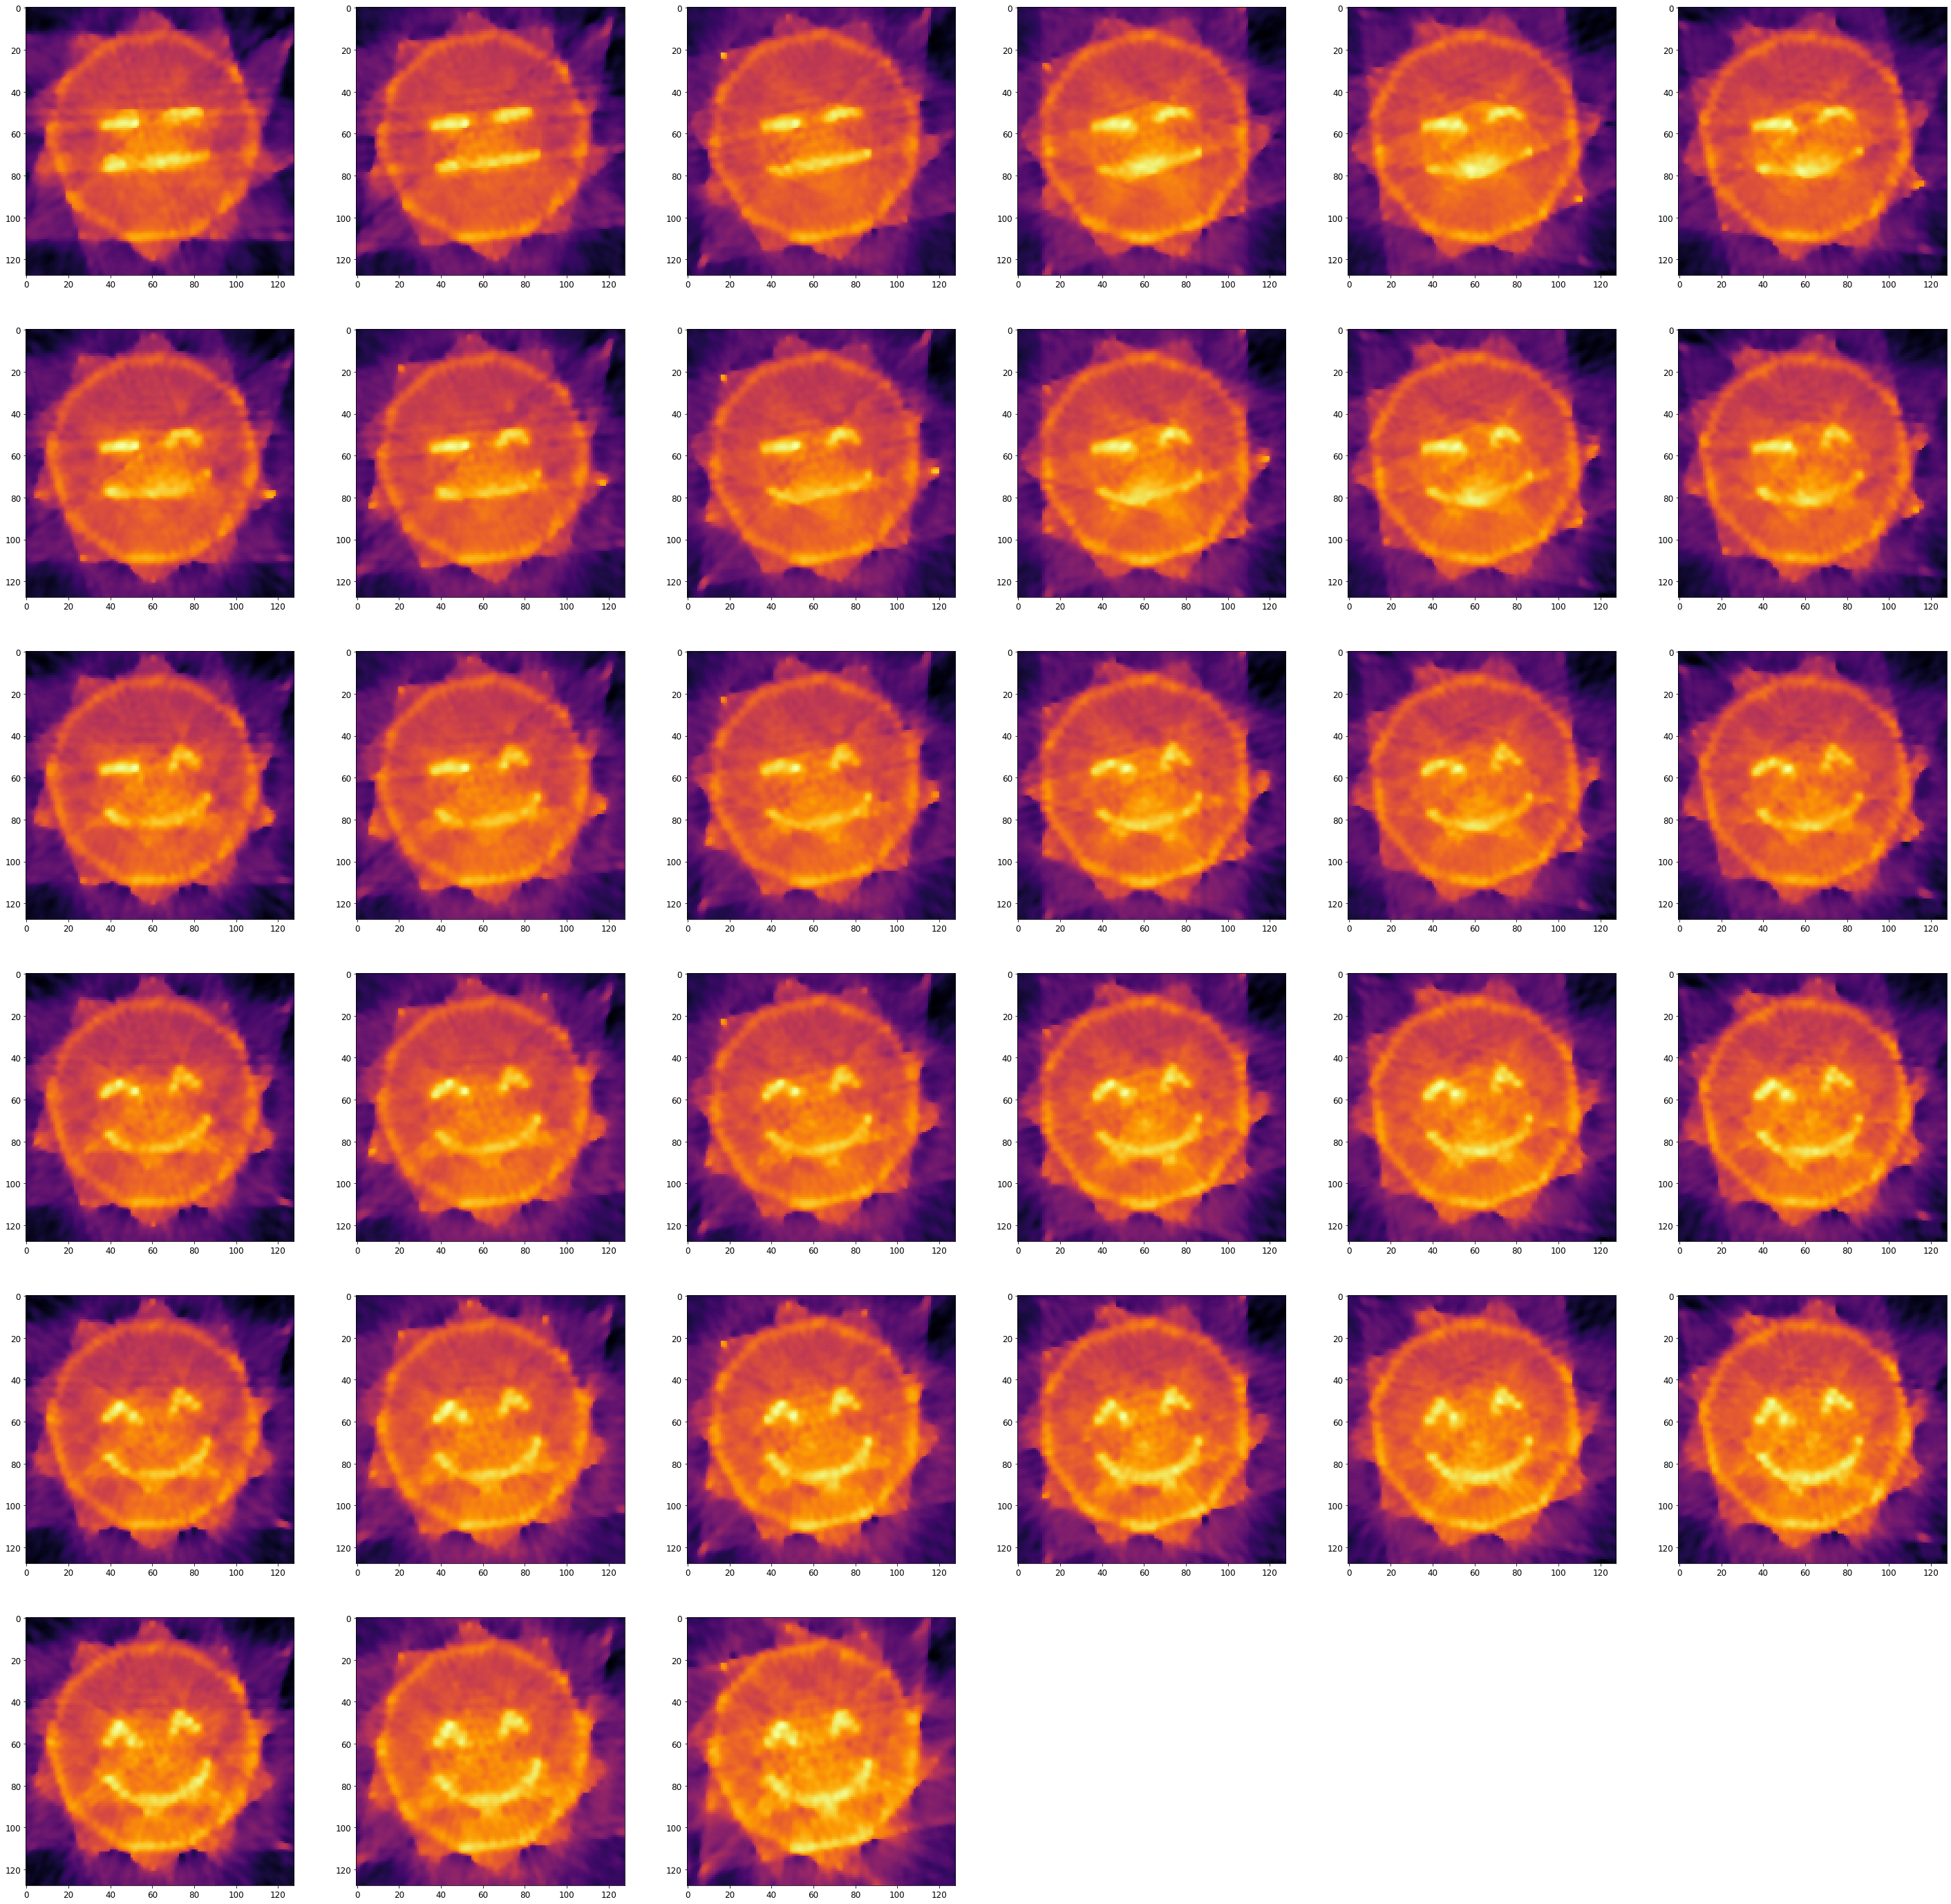

In [60]:
plot_recstructions_series(x_mmgks, (nx, ny, nt), dynamic = True, testproblem = 'Emoji', geome_x = 1,geome_x_small = 0,  save_imgs= False, save_path='./reconstruction/Emoji')